In [34]:
from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
import time

from sklearn.datasets import load_iris

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from scipy import sparse
from scipy.sparse import issparse
from scipy.stats import gaussian_kde
import copy

### Kernel Density Estimation 

In [35]:
class KDE:
    
    def __init__(self, data_points, width=None):

        """
        Kernel Density Estimation (KDE) class for estimating probability density functions.

        Args:
            data_points (numpy.ndarray): An array of data points for which to estimate the density.
            width (float): The width of the kernel function. If not provided, it is determined using
                          Scott's factor for multi-dimensional data.

        Attributes:
            data_points (numpy.ndarray): The input data points for density estimation.
            num_points (int): The number of data points.
            dim (int): The dimensionality of the data points.
            width (float): The width of the kernel function.

        Methods:
            __call__(x):
                Estimate the probability density at the given point(s).

        Usage:
        # Initialize KDE with data_points and an optional width
        kde = KDE(data_points, width)

        # Estimate the density at a specific point(s)
        density = kde(x)

        For more information on KDE and usage, refer to:
        https://en.wikipedia.org/wiki/Kernel_density_estimation
        
        
        *This doc-string was written by ChatGPT on September 19th, 2023*
        """        
        
        if len(data_points.shape)==1:
            self.data_points = data_points.reshape(-1,1)
        else:
            self.data_points = data_points
        self.num_points, self.dim = self.data_points.shape
        
        if width is None: # scott's factor; https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
            width = (self.num_points)**(-1/(self.dim+4))
        self.width = width        
    
    def __call__(self, x):
        
        """
        Estimate the probability density at the given point(s).

        Args:
            x (float, int, list, numpy.ndarray): The point(s) at which to estimate the density.

        Returns:
            float: The estimated probability density at the given point(s).
            
        
        *This doc-string was written by ChatGPT on September 19th, 2023* 
        """        
        
        # converting float to matrix
        if isinstance(x, float) or isinstance(x, int):
            x = np.array([[x]])
            assert self.dim == 1
            
        elif isinstance(x, list):
            x = np.array([x])
            assert self.dim == 1
        
        if len(x.shape)==1:
            x = x.reshape(1,-1)
                    
        # ensuring same shape between input point and data values
        assert x.shape[1] == self.data_points[:,:1].shape[1]
        
        # computing density estimate
        rho_res = np.sum(np.exp(-(x-self.data_points)**2/self.width**2))/(np.sqrt(2*np.pi*self.width**2)**self.dim)/self.num_points
        
        return rho_res

In [36]:
# Values for KDE
xvals = np.random.lognormal(mean = 4.0, sigma = 1.0, size = 1000)
xrange = np.linspace(0,300,1000)
KDE_func = KDE(data_points=xvals, width =30.0)
kde_vals = np.array([KDE_func(x) for x in xrange])

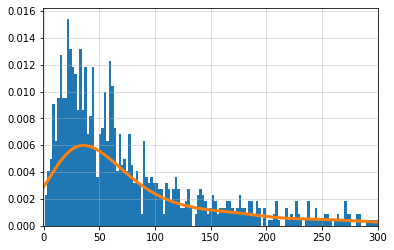

In [37]:
# Histogram plot
plt.hist(xvals, bins = 400, density=True)
plt.plot(xrange, kde_vals, linewidth = 3.0)
plt.xlim([-1,300])
plt.grid(alpha = 0.5)
plt.show()

### Bayesian Estimate of Learning Potential 

In [85]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import issparse
        
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import gaussian_kde


def bayesian_loss_estimate_KDE(df=None, X=None, y=None, class_label=None, width = 1.0):
    
    """
    Computes the base_loss, minimum loss, learning potential based on probabilistic analysis.

    Args:
        data_frame (pandas.DataFrame): The input DataFrame containing features and class labels.
        class_label (str): The name of the column in the DataFrame containing class labels.

    Returns:
        tuple: A tuple containing the following values:
            - L_0 (float): Base cross-entropy computed from class label distribution.
            - L (float): Data-inferred cross-entropy loss based on feature distributions.
            - Q (float): Learning potential, indicating the potential improvement in loss.

    This function performs probabilistic analysis to compute the minimum loss and learning potential
    based on Gaussian KDE (Kernel Density Estimation) of sampled features.

    Steps:
    1. One-hot encodes the class labels and defines base probabilities.
    2. Obtains samples based on class labels and computes Gaussian KDE for each class.
    3. Defines base feature probability function.
    4. Computes the matrix of probability ratios for each data point and class.
    5. Calculates base cross-entropy (L_0) and data-inferred loss (L).
    6. Computes learning potential (Q) as the improvement in loss.

    Example:
        L_0, L, Q = minimum_loss(data_frame, 'class_label')

    Note:
        This function assumes that the input DataFrame contains both features and class labels,
        and the 'class_label' column is used as the target class label for analysis.
        
        *This doc-string was written by ChatGPT on August 31st, 2023*
    """    
    
    if (df is not None) and (class_label is not None) and (X is None and y is None):   
        # feature and class definitions and one-hot encoding
        X = df.drop(columns=[class_label]).values
        y = list(df[class_label])
        y_matrix = np.array(pd.get_dummies(df[class_label]))  
        
    elif (X is not None) and (y is not None):
        if issparse(X):
            svd = TruncatedSVD(n_components=10, random_state=42)
            X = svd.fit_transform(X) 
            print('Matrix is sparse. Converting to 10-dim dense vector with Truncated SVD. Percentage of variance explained by new representation is',np.sum(svd.explained_variance_ratio_))
            
        y = y.reshape(-1, 1) # reshape the array to a column vector (required by OneHotEncoder)
        one_hot_encoded = OneHotEncoder().fit_transform(y) # fit and transform the data to one-hot encoding
        y_matrix = one_hot_encoded.toarray() # convert the one-hot encoded sparse matrix to an array
        
    else:
        print('Missing arguments! Must provide data frame AND class label OR X AND y values')
        return

    # getting base probabilities 
    p_alpha = np.sum(y_matrix, axis = 0)/len(y_matrix)

    # getting samples based on classes
    num_classes = y_matrix.shape[1]
    sampled_features_dict = dict()
    for j in range(num_classes):
        sampled_features_dict[j] = np.array([X[k,:].tolist() for k in range(len(y_matrix)) if y_matrix[k,j] == True])

    # gaussian kde of sampled features
    rho_kde_dict = dict()
    for j in range(num_classes):
        rho_kde_dict[j] = gaussian_kde(sampled_features_dict[j].T)   

    # defining base feature probability
    prob_x = lambda x: np.sum([p_alpha[j]*rho_kde_dict[j](x) for j in range(num_classes)])  

    # getting matrix of probability ratios 
    prob_ratios = np.array([[rho_kde_dict[j](X[i])[0]/prob_x(X[i]) for j in range(num_classes)] for i in range(len(y_matrix))])

    # eliminate possibility of divide by zero errors
    prob_ratios = prob_ratios + 1e-10
    
    # base cross entropy
    L_0 = -np.sum(p_alpha*np.log(p_alpha))

    # computing data inferred loss
    L = L_0 -np.sum((y_matrix*np.log(prob_ratios)))/len(y_matrix)

    # computing learning potential
    Q = (L_0-L)/L_0

    return L_0, L, Q

## Bayesian Estimate of Minimum Loss

**(August 30, 2023)**

Say that we have a data set ${\cal D}$ consisting of points in feature space $\textbf{x}_i \in \mathbb{R}^{M}$ and their corresponding classes $y_i\in U$ where $U$ is the set of all classes. Another way to write the data set is as ${\cal D} = \{\{\textbf{x}_i, y_i\}; i=1, \ldots, N\}$. We will one-hot-encode these labels so that $y_{i, \alpha} \in \{0, 1\}$ and $\alpha = 1, \cdots, C$ for $C$ classes. The principal task of machine learning is to generate a function $ \hat{p}(\alpha|\textbf{x})$ that tells us the probability that a data point with feature representation $\textbf{x}$ has class $\alpha$. In most ML manifestations of this problem, the goal is to minimize the function
\begin{equation}
{\cal L} = - \frac{1}{N}\sum_{\alpha=1}^C\sum_{i=1}^N y_{ i, \alpha} \ln \hat{p}(\alpha|\textbf{x}_i). 
\label{eq:cross_ent}
\end{equation}
Can we use a Bayesian argument to estimate what the minimum value of this loss can be when we train an ML model?

**Solution:**

We find

\begin{equation}
{\cal L} = -\sum_{\alpha=1}^C \hat{p}(\alpha)\ln \hat{p}(\alpha) - \frac{1}{N} \sum_{\alpha=1}^C \sum_{i=1}^N y_{i, \alpha} \ln \left[\frac{\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha)}{\sum_{\alpha'=1}^C\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha') \hat{p}(\alpha') }\right].
\end{equation} 

The first term above represents the loss we would expect from just predicting class probabilities from a frequency count of the classes in the data; we denote this term ${\cal L}_0$. If our model has managed to learn anything about class-assignment from the data, then we would expect the loss to be lower than ${\cal L}_0$.

With the above expected loss, we can define how much we expect to learn from from a given data set. We define the \textit{learning quotient} ${\cal Q}$ as 

\begin{equation}
{\cal Q} \equiv \frac{{\cal L}_0-{\cal L}}{{\cal L}_0} = \frac{1}{N{\cal L}_0} \sum_{\alpha=1}^C \sum_{i=1}^N y_{i, \alpha} \ln \left[\frac{\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha)}{\sum_{\alpha'=1}^C\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha') \hat{p}(\alpha') }\right]
\end{equation}

representing the fractional decrease in loss we expect from the naive class-frequency-based estimate of loss. Given that ${\cal L}\geq0$ and ${\cal L} \leq {\cal L}_0$, we find that ${\cal Q} \in [0, 1]$. The quantity ${\cal Q}$ answers the following question.

> Given the data set ${\cal D}= \{\{\textbf{x}_i, y_i\}; i=1, \ldots, N\}$, how predictive is feature $\textbf{x}$ of class $\alpha$? *(The value $0$ corresponds to not at all predictive and $1$ corresponds to maximally predictive.)* 



### Single-Variable Data

In [86]:
# parameter choices
mu_R, sigma_R = 40, 15
mu_C, sigma_C = 30, 10
N_C, N_R = 600, 1200

# creating the churned and renewed random points
x1 =  np.random.randn(N_R)
x2 =  np.random.randn(N_C)
x_R = x1*sigma_R + mu_R
x_C = x2*sigma_C + mu_C

# #
x_C = np.round(x_C)*5-5
x_R = np.round(x_R)*5

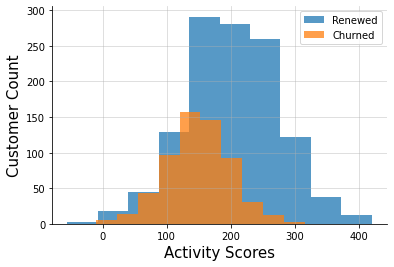

In [87]:
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

plt.hist(x_R, bins = 10, alpha = 0.75, label='Renewed')
plt.hist(x_C, bins = 10, alpha = 0.75, label='Churned')
plt.grid(alpha = 0.5)
plt.xlabel('Activity Scores', fontsize = 15)
plt.ylabel('Customer Count', fontsize = 15)
plt.legend(loc = 'best', fontsize = 10)
plt.show()

In [88]:
# creating data frame for results
engagement_scores = x_R.tolist() + x_C.tolist()
churn_statuses = ['Renewed']*len(x_R) + ['Churned']*len(x_C)
data_dict = {'activity_score': engagement_scores,
                                   'status': churn_statuses}
# define dataframe and shuffle rows
df = pd.DataFrame.from_dict(data = data_dict)
df = df.sample(frac=1).reset_index(drop=True)

In [89]:
df.head(7)

,activity_score,status
0,170.0,Churned
1,245.0,Renewed
2,310.0,Renewed
3,155.0,Churned
4,130.0,Churned
5,150.0,Churned
6,130.0,Renewed


In [90]:
# feature and class definitions and one-hot encoding
X = np.array(df['activity_score']).reshape(-1, 1)
y = np.array(list(df['status']))
y_matrix = np.array(pd.get_dummies(df['status']))

### Theoretical Estimate of Minimum Loss

\begin{equation}
{\cal L} = -\sum_{\alpha=1}^C \hat{p}(\alpha)\ln \hat{p}(\alpha) - \frac{1}{N} \sum_{\alpha=1}^C \sum_{i=1}^N y_{i, \alpha} \ln \left[\frac{\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha)}{\sum_{\alpha'=1}^C\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha') \hat{p}(\alpha') }\right].
\end{equation} 

The first term above represents the loss we would expect from just predicting class probabilities from a frequency count of the classes in the data; we denote this term ${\cal L}_0$. If our model has managed to learn anything about class-assignment from the data, then we would expect the loss to be lower than ${\cal L}_0$.

With the above expected loss, we can define how much we expect to learn from from a given data set. We define the \textit{learning quotient} ${\cal Q}$ as 

\begin{equation}
{\cal Q} \equiv \frac{{\cal L}_0-{\cal L}}{{\cal L}_0} = \frac{1}{N{\cal L}_0} \sum_{\alpha=1}^C \sum_{i=1}^N y_{i, \alpha} \ln \left[\frac{\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha)}{\sum_{\alpha'=1}^C\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha') \hat{p}(\alpha') }\right]
\end{equation}

In [91]:
L_0, L, Q = bayesian_loss_estimate_KDE(X=X, y = y)
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Naive Maximum Loss: 0.6365141682948128
Potential Minimum Loss: 0.5413713257232045
Learning Potential from Features: 0.14947482288806058


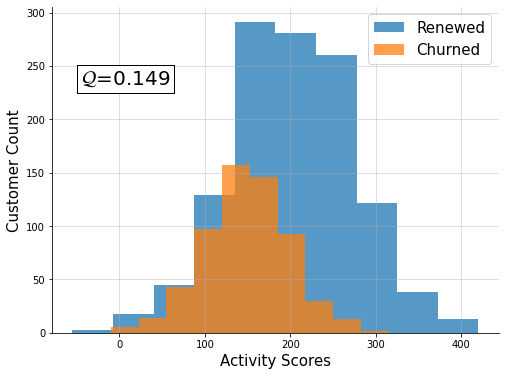

In [92]:
# plt.figure()
fig, ax = plt.subplots(figsize = (8,6))

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

plt.hist(x_R, bins = 10, alpha = 0.75, label='Renewed')
plt.hist(x_C, bins = 10, alpha = 0.75, label='Churned')
plt.grid(alpha = 0.5)
plt.xlabel('Activity Scores', fontsize = 15)
plt.ylabel('Customer Count', fontsize = 15)
plt.legend(loc = 'best', fontsize = 15)
# Create a text object and add it to the axis
text_box = fig.text(0.175, 0.7, r'${\cal Q}$='+str(round(Q,3)), fontsize=20, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.add_artist(text_box)
plt.show()

## Applications Questions

#### What questions does this formalism help one answer?

1. **Minimum Loss Prediction:** What is the minimum loss we expect from a trained model? Can we use this limit to determine if a model has been over-trained?
    

2. **Fundamental Question of ML:** Does knowing $\textbf{x}_i$ have the potential to help determine class $y_i$?
    
   
3. **Most Valuable Features:** Which features or feature combinations have the highest learning potential (i.e., can best help to distinguish classes without overtraining)?

### 1. Minimum Loss Prediction

What is the minimum loss we expect for the model? When do we know the model has been over-trained?

> *Answer:* The minimum loss we expect to get from the data is ${\cal L}$. If the loss is below this value then Bayes rule is violated (i.e., we're inferring probabilities distinct from their true values) and the model has been overtrained. 

In [93]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Naive Bayes

In [94]:
# NAIVE BAYES CLASSIFICATION 
nb_clf = GaussianNB().fit(X_train, y_train)
# getting naive bayes probabilities 
nb_probs_train = nb_clf.predict_proba(X_train)

In [95]:
# calculation of loss entropy; k-nearest neighbor
y_ialpha = np.array(pd.get_dummies(y_train))
loss_entropy0 =  -np.sum(np.log(nb_probs_train+1e-10)*y_ialpha)/(len(y_ialpha))
print('Model Loss:', loss_entropy0)
print('Bayesian Estimate of Minimum Loss:', L)

Model Loss: 0.5272296411143825
Bayesian Estimate of Minimum Loss: 0.5413713257232045


**Consistent with the limit!**

In [96]:
# checking the overfitting

# Make predictions on the test data
y_pred_train = nb_clf.predict(X_train)
y_pred_test = nb_clf.predict(X_test)

# Calculate the accuracy of the classifier
train_accuracy = balanced_accuracy_score(y_train, y_pred_train)
test_accuracy = balanced_accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.6388817679267483
Test Accuracy: 0.5997181113460184


#### KNearest Neighbors

In [107]:
# KNN CLASSIFICATION 
knn_clf = KNeighborsClassifier(n_neighbors=20).fit(X_train, y_train)
# getting knn probabilities 
knn_probs_train = knn_clf.predict_proba(X_train)
small_value = 1e-30 # Define a small non-zero value
knn_probs_train[knn_probs_train == 0] = small_value # Replace zero values with the small value

In [108]:
# calculation of loss entropy; k-nearest neighbor
y_ialpha = np.array(pd.get_dummies(y_train))
loss_entropy2 =  -np.sum(np.log(knn_probs_train+1e-10)*y_ialpha)/(len(y_ialpha))
print('Model Loss:', loss_entropy2)
print('Bayesian Estimate of Minimum Loss:', L)

Model Loss: 0.5350519457949411
Bayesian Estimate of Minimum Loss: 0.5413713257232045


***Overfitted!***

In [109]:
# checking the overfitting

# Make predictions on the test data
y_pred_train = knn_clf.predict(X_train)
y_pred_test = knn_clf.predict(X_test)

# Calculate the accuracy of the classifier
train_accuracy = balanced_accuracy_score(y_train, y_pred_train)
test_accuracy = balanced_accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.6420664813025445
Test Accuracy: 0.5668982180610087


#### Decision Tree Classification

In [110]:
# DECISION TREE CLASSIFICATION
tree_clf =  DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
# getting tree probabilities 
tree_probs_train = tree_clf.predict_proba(X_train)
small_value = 1e-30 # Define a small non-zero value
tree_probs_train[tree_probs_train == 0] = small_value # Replace zero values with the small value

In [111]:
# calculation of loss entropy; decision tree
y_ialpha = np.array(pd.get_dummies(y_train))
loss_entropy3 = -np.sum(np.log(tree_probs_train+1e-10)*y_ialpha)/(len(y_ialpha))
print('Model Loss:', loss_entropy3)
print('Bayesian Estimate of Minimum Loss:', L)

Model Loss: 0.5077746547739472
Bayesian Estimate of Minimum Loss: 0.5413713257232045


***Overfitted!***

In [112]:
### Checking the overfitting

# Make predictions on the test data
y_pred_train = tree_clf.predict(X_train)
y_pred_test = tree_clf.predict(X_test)

# Calculate the accuracy of the classifier
train_accuracy = balanced_accuracy_score(y_train, y_pred_train)
test_accuracy = balanced_accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.6389540730807912
Test Accuracy: 0.5847679452330615


#### Logistic Regression

In [113]:
# LOGISTIC REGRESSION CLASSIFICATION
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
# getting log regression probs
log_reg_probs_train = clf.predict_proba(X_train)

In [114]:
# calculation of loss entropy; logistic regression
y_ialpha = np.array(pd.get_dummies(y_train))
loss_entropy = -np.sum(np.log(log_reg_probs_train)*y_ialpha)/(len(y_ialpha))
print('Model Loss:', loss_entropy)
print('Bayesian Estimate of Minimum Loss:', L)

Model Loss: 0.5540440832285047
Bayesian Estimate of Minimum Loss: 0.5413713257232045


**This one is consistent with the limit!**

In [115]:
# Checking the underfitting

# Make predictions on the test data
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Calculate the accuracy of the classifier
train_accuracy = balanced_accuracy_score(y_train, y_pred_train)
test_accuracy = balanced_accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.5862140364023585
Test Accuracy: 0.5956911305748516


#### Neural Network Example 

In [116]:
from keras.backend import clear_session
clear_session()

In [117]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_matrix[:,0], test_size=0.2, random_state=42)

In [118]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))-0.5

In [119]:
from keras.models import Sequential
from keras import layers
from keras import backend as K

input_dim = X.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(2, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [120]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

K.set_value(model.optimizer.learning_rate, 0.0005)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 4         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 7 (28.00 Byte)
Trainable params: 7 (28.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [121]:
history = model.fit(NormalizeData(X_train), y_train,
                    epochs=200,
                    verbose=False,
                    validation_data=(NormalizeData(X_test), y_test),
                    batch_size=10)

In [122]:
loss, accuracy = model.evaluate(NormalizeData(X_train), y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(NormalizeData(X_test), y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6896
Testing Accuracy:  0.6056


In [123]:
import matplotlib.pyplot as plt

def plot_history(history, min_loss = None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.grid(alpha = 0.5)
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.grid(alpha = 0.5)
    plt.title('Training and validation loss')
    if min_loss:
        plt.axhline(y = min_loss, linestyle = ':', linewidth=3, color = 'k', label = 'Bayesian minimum loss estimate')
    plt.legend()
#     plt.savefig('bayesian_loss_neural_network.png', bbox_inches = 'tight')
    plt.show()

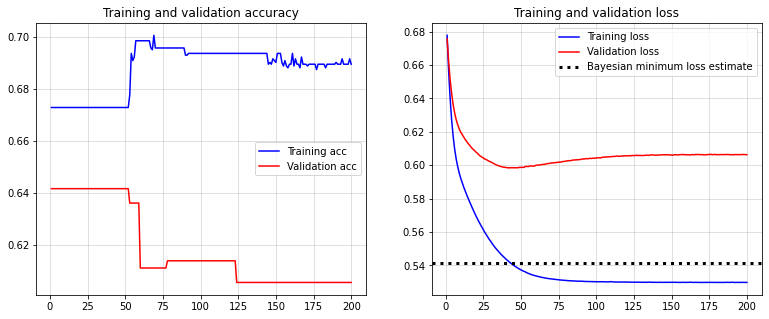

In [124]:
plot_history(history, min_loss = L)

### 2. Fundamental Question of ML: Can we learn from this data?

Does knowing $\textbf{x}$ have the potential to help determine class $y$?

> *Answer:* We can use the value of the learning potential ${\cal Q}$ to determine how well $\textbf{x}$ can determine $y$. The closer ${\cal Q}$ is to 1, the better $textbf{x}$ is at distinguishing $y$. 

#### Iris Data Set

In [125]:
from sklearn.datasets import load_iris

iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_iris['target'] = iris.target

In [126]:
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [128]:
L_0, L, Q = bayesian_loss_estimate_KDE(df=df_iris, class_label='target')
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Naive Maximum Loss: 1.0986122886681096
Potential Minimum Loss: 0.016470019259333224
Learning Potential from Features: 0.9850083424068554


#### Wines Dataset

In [129]:
from sklearn.datasets import load_wine

wines = load_wine()
df_wines = pd.DataFrame(data=wines.data, columns=wines.feature_names)
df_wines['target'] = wines.target

In [130]:
df_wines

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [132]:
L_0, L, Q = bayesian_loss_estimate_KDE(df=df_wines, class_label='target')
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Naive Maximum Loss: 1.086038443640683
Potential Minimum Loss: 0.00017672382597599956
Learning Potential from Features: 0.9998372766387683


#### Breast Cancer Dataset

In [133]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
df_bc = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
df_bc['target'] = breast_cancer.target

In [134]:
df_bc

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [135]:
L_0, L, Q = bayesian_loss_estimate_KDE(df=df_bc, class_label='target')
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Naive Maximum Loss: 0.6603163491952275
Potential Minimum Loss: 0.012673744295453426
Learning Potential from Features: 0.9808065568709607


#### NewsGroup Dataset

In [136]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Preprocess the text data
preprocessed_texts = newsgroups.data
labels = newsgroups.target

In [137]:
print('Label:', labels[0])
print('Text:', preprocessed_texts[0])

Label: 10
Text: 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [138]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the text data using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [140]:
L_0, L, Q = bayesian_loss_estimate_KDE(X = tfidf_matrix, y = labels)
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Matrix is sparse. Converting to 10-dim dense vector with Truncated SVD. Percentage of variance explained by new representation is 0.05649181318179803
Naive Maximum Loss: 2.990257141388216
Potential Minimum Loss: 0.9635703468570234
Learning Potential from Features: 0.6777633824462035


#### Digits Dataset

In [141]:
from sklearn.datasets import load_digits

digits = load_digits()
df_digits = pd.DataFrame(data=digits.data, columns=digits.feature_names)
X_digits = sparse.csr_matrix(digits.data)
y_digits = digits.target

In [142]:
L_0, L, Q = bayesian_loss_estimate_KDE(X=X_digits, y=y_digits)
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Matrix is sparse. Converting to 10-dim dense vector with Truncated SVD. Percentage of variance explained by new representation is 0.7324265017215523
Naive Maximum Loss: 2.302479220967876
Potential Minimum Loss: 0.0005422145565305847
Learning Potential from Features: 0.9997645083822722


### 3. Most Valuable Features

Which features or feature combinations have the highest learning potential (i.e., can best help to distinguish classes without overtraining)?

> *Answer:* The features or feature combinations that bring ${\cal Q}$ closest to 1.

#### Addendum: Dealing with multidimensional data

We want to extend this formalism to account for when we have multiple feature columns. We've already done this with some of the python data set examples above, but now we want to give a concrete example. 

In [143]:
import numpy as np

# Define the mean vector and correlation matrix
mu_vec_R = np.array([30, 40])
corr_mat_R = np.array([[10.0, 7.5], [7.5, 15.0]])

mu_vec_C = np.array([30, 50])
corr_mat_C = np.array([[10.0, 0.0], [0.0, 20.0]])

# Generate random samples from the multivariate normal distribution
N_C, N_R = 600, 1200  # Number of samples to generate
samples_C = np.random.multivariate_normal(mu_vec_C, corr_mat_C, size=N_C)
samples_R =  np.random.multivariate_normal(mu_vec_R, corr_mat_R, size=N_R)

In [144]:
# defining dataframe
samples_full = np.concatenate((samples_C, samples_R), axis=0)
classes = ['Churned']*N_C + ['Renewed']*N_R

In [145]:
column_names = ['feature1', 'feature2'] # define column names
multi_df = pd.DataFrame(samples_full, columns=column_names) # Create a DataFrame from the array
multi_df['status'] = classes # addding class label
multi_df = multi_df.sample(frac=1).reset_index(drop=True) # shuffling labels

In [146]:
# showing dataframe of features
multi_df.head(7)

,feature1,feature2,status
0,29.121566,51.867780,Churned
1,31.362488,42.895940,Renewed
2,30.618493,39.389622,Renewed
3,32.064376,47.866771,Churned
4,31.745029,46.735967,Churned
5,26.428866,34.782022,Renewed
6,31.609372,47.704605,Churned


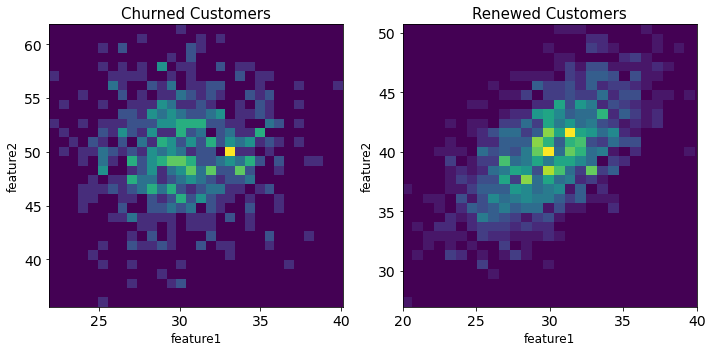

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example x-y data points for two datasets
xC, yC = samples_C.T
xR, yR = samples_R.T

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot first two-dimensional histogram
hist1 = ax1.hist2d(xC, yC, bins=30, cmap='viridis')
ax1.set_xlabel('feature1', fontsize = 12)
ax1.set_ylabel('feature2', fontsize = 12)
# ax1.set_xlim([20,40])
ax1.set_title('Churned Customers', fontsize = 15)
ax1.tick_params(axis='both', labelsize=14)
# ax1.colorbar(label='Density')

# Plot second two-dimensional histogram
hist2 = ax2.hist2d(xR, yR, bins=30, cmap='viridis')
ax2.set_xlabel('feature1', fontsize = 12)
ax2.set_ylabel('feature2', fontsize = 12)
ax2.set_xlim([20,40])
ax2.set_title('Renewed Customers', fontsize = 15)
ax2.tick_params(axis='both', labelsize=14)
# ax2.colorbar(label='Density')

plt.tight_layout()
# plt.savefig('bayesian_loss_two_features.png', bbox_inches = 'tight')
plt.show()

In [148]:
## 
# ALL FEATURES
##

L_0, L, Q = bayesian_loss_estimate_KDE(df=multi_df, class_label='status')
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Naive Maximum Loss: 0.6365141682948128
Potential Minimum Loss: 0.20124279913696058
Learning Potential from Features: 0.6838361042675936


In [149]:
## 
# FIRST FEATURE
##
L_0, L, Q = bayesian_loss_estimate_KDE(df=multi_df[['feature1', 'status']], class_label='status')
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Naive Maximum Loss: 0.6365141682948128
Potential Minimum Loss: 0.6328471114943863
Learning Potential from Features: 0.005761155026996959


In [150]:
## 
# SECOND FEATURE 
##
L_0, L, Q = bayesian_loss_estimate_KDE(df=multi_df[['feature2', 'status']], class_label='status')
print('Naive Maximum Loss:', L_0)
print('Potential Minimum Loss:', L)
print('Learning Potential from Features:', Q)

Naive Maximum Loss: 0.6365141682948128
Potential Minimum Loss: 0.23831873430091527
Learning Potential from Features: 0.6255876991091049


In [151]:
data = {
    "Learning potential": [0.002899817863335521, 0.6193098935075712, 0.6833437666645646]
}

index = ["feature1", "feature2", "feature1 & feature2"]

# Create the DataFrame
df = pd.DataFrame(data, index=index)

df

,Learning potential
feature1,0.002900
feature2,0.619310
feature1 & feature2,0.683344


First feature has more learning potential than second feature so it can better distinguish the two classes. However the two features together do better than each one of them alone. 

#### Summary

**Main Results**
\begin{equation}
{\cal L} = -\sum_{\alpha=1}^C \hat{p}(\alpha)\ln \hat{p}(\alpha) - \frac{1}{N} \sum_{\alpha=1}^C \sum_{i=1}^N y_{i, \alpha} \ln \left[\frac{\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha)}{\sum_{\alpha'=1}^C\hat{\rho}_{\text{KDE}}(\textbf{x}_i|\alpha') \hat{p}(\alpha') }\right]\qquad \text{[Bayesian Estimate of Loss]}
\end{equation} 

\begin{equation}
{\cal Q} \equiv \frac{{\cal L}_0-{\cal L}}{{\cal L}_0}; \quad {\cal L}_0 = -\sum_{\alpha=1}^C \hat{p}(\alpha)\ln \hat{p}(\alpha)\qquad \text{[Learning Quotient]}
\end{equation}

We found three applications of these results
- **Minimum Loss:** 
    - Computing the Bayesian expected loss and the loss of a trained model can provide a signal for when a model has been overtrained.


- **Learning Quotient and Trainability:** 
    - Learning quotient can tell us how much a model can learn from a feature data set. 
    
    
- **Feature Importance:** 
    - Comparing learning quotients can tell us which combinations of features are most important

---------

----------


----------